# Colour - HDRI - Examples: Merge from Raw Files using Rawpy

Through this example, some Canon EOS 5D Mark II *CR2* files will be merged together in order to create a single radiance image.

The following steps will be taken:

- Creation of an image stack using *CR2* files:
    - Reading of the *CR2* files *Exif* metadata using Phil Harvey's [ExifTool](http://www.sno.phy.queensu.ca/~phil/exiftool/).
    - Reading of the *CR2* files pixel data using [rawpy](https://github.com/neothemachine/rawpy).
- Merging of the image stack into a radiance image.
- Display of the final resulting radiance image.

## Raw Files Filtering

In [1]:
% matplotlib inline

In [2]:
import logging
import numpy as np
import os
import rawpy

import colour
from colour.plotting import *

from colour_hdri import (
    EXAMPLES_RESOURCES_DIRECTORY,
    Image,
    ImageStack,
    camera_space_to_sRGB,
    convert_dng_files_to_intermediate_files,
    convert_raw_files_to_dng_files,
    filter_files,
    read_exif_tag,
    highlights_recovery_blend,
    image_stack_to_radiance_image,
    radiance_image_strip_plot,
    update_exif_tags,
    weighting_function_Debevec1997)

LOGGER = logging.getLogger()
LOGGER.setLevel(logging.DEBUG)

OECF = colour.RGB_COLOURSPACES['sRGB'].OECF

RESOURCES_DIRECTORY = os.path.join(EXAMPLES_RESOURCES_DIRECTORY,
                                   'frobisher_001')

In [3]:
RAW_FILES = filter_files(RESOURCES_DIRECTORY, ('CR2',))

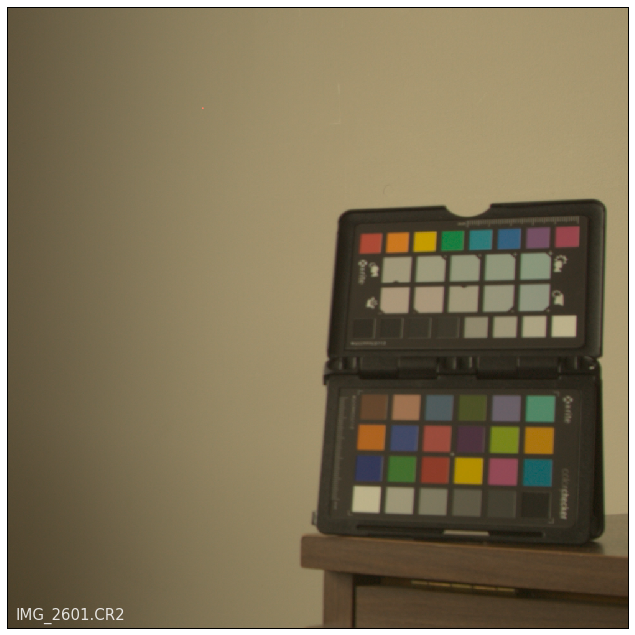

True

In [4]:
def read_raw_file(path):
    raw = rawpy.imread(path).postprocess(gamma=(1,1), 
                                         no_auto_bright=True, 
                                         output_bps=16)
    return raw.astype(float) / 65535.
    
    
image_plot(OECF(read_raw_file(RAW_FILES[-2])[1250:2250, 3000:4000, ...]),
           os.path.basename(RAW_FILES[-2]))

## Radiance Image Merge

In [5]:
def merge_from_raw_files_using_rawpy(
        raw_files,
        output_directory,
        batch_size=5,
        weighting_function=weighting_function_Debevec1997):
    for raw_files in colour.batch(raw_files, batch_size):
        image_stack = ImageStack()
        for raw_file in raw_files:
            image = Image(raw_file)
            image.read_metadata()
            image.data = read_raw_file(raw_file)
            image_stack.append(image)

        path = os.path.join(
            output_directory,
            '{0}_{1}_MRFUR.{2}'.format(
                os.path.splitext(os.path.basename(image_stack.path[0]))[0],
                batch_size,
                'exr'))

        LOGGER.info('Merging "{0}"...'.format(path))
        LOGGER.info('\tImage stack "F Number" (Exif): {0}'.format(
            image_stack.f_number))
        LOGGER.info('\tImage stack "Exposure Time" (Exif): {0}'.format(
            image_stack.exposure_time))
        LOGGER.info('\tImage stack "ISO" (Exif): {0}'.format(
            image_stack.iso))
        image = image_stack_to_radiance_image(image_stack,
                                              weighting_function,
                                              weighting_average=True)

        LOGGER.info('Writing "{0}"...'.format(path))
        colour.write_image(image, path)

        return image, path


IMAGE, PATH = merge_from_raw_files_using_rawpy(
    RAW_FILES, RESOURCES_DIRECTORY)

INFO:colour_hdri.utilities.image:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/../resources/colour-hdri-examples-dataset/frobisher_001/IMG_2598.CR2" image metadata.
INFO:colour_hdri.utilities.exif:Reading '/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/../resources/colour-hdri-examples-dataset/frobisher_001/IMG_2598.CR2' image exif data.
INFO:colour_hdri.utilities.image:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/../resources/colour-hdri-examples-dataset/frobisher_001/IMG_2599.CR2" image metadata.
INFO:colour_hdri.utilities.exif:Reading '/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/../resources/colour-hdri-examples-dataset/frobisher_001/IMG_2599.CR2' image exif data.
INFO:colour_hdri.utilities.image:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/../resource

## Radiance Image Display

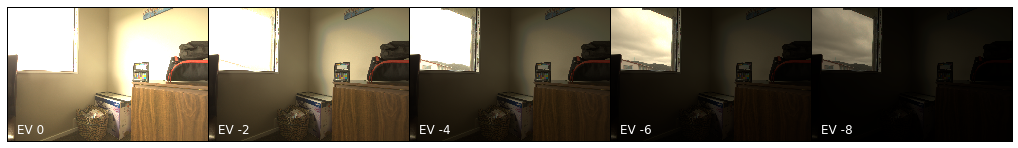

True

In [6]:
radiance_image_strip_plot(IMAGE)